# EcoLens : LCA tool

This notebook is a toy example of the LCA tool that EcoLens intend to develop. 

The data is from: http://agribalyse.ademe.fr
<br>
The method used is the Product Environmental Footprint: https://ec.europa.eu/environment/eussd/pdf/footprint/PEF%20methodology%20final%20draft.pdf

The final score is computed as follow: 
<br>
*score* = $\sum_{i=1}^{N}$ { *impact_result* / *normalization_factor* $*$ *weighting* }, where N is the number of categories of impacts considered.
<br>
The *impact_result* values can be found in the *results.csv* file, while *normalization_factor* and *weighting* can be found in the *impact_categories.csv* file.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

%matplotlib inline

In [4]:
DATA_FOLDER = 'data/'

LCA_RESULTS = DATA_FOLDER + "results.csv"
LCA_COMPARISON = DATA_FOLDER + "meals_comparison.csv"
AGRBALYSE_CATEGORIES = DATA_FOLDER + "impact_categories.csv"
LCA_PER_INGREDIENT = DATA_FOLDER + "result_per_ingredient.csv"

results = pd.read_csv(LCA_RESULTS, delimiter = ';', usecols = [0,6,7], names = ['name', 'impact_result','unit'], header=0)
comparison = pd.read_csv(LCA_COMPARISON, delimiter = ';', usecols = [0,6,7,8], names = ['name', 'impact_result','unit', 'meal'], header = 0)
categories = pd.read_csv(AGRBALYSE_CATEGORIES, delimiter = ';', names = ['name', 'unit','normalization_factor','weighting','recommendation'], header=0)
ingredients = pd.read_csv(LCA_PER_INGREDIENT, delimiter = ';', names = ['impact_category', 'contribution', 'process', 'amount', 'unit'], header=0)

The *result.csv* file contains the results of the Life Cycle Assessment (LCA) of one product under study. The following features are used :
- *name*: name of the impact category
- *impact_result*: numerical value of the concerned impact category
- *unit*: physical unit of the impact category

In [3]:
results.head()

,name,impact_result,unit
0,"Human toxicity, non-cancer",8.924770e-08,CTUh
1,"Human toxicity, non-cancer - inorganics",6.681480e-09,CTUh
2,"Resource use, fossils",3.303750e+01,MJ
3,"Eutrophication, marine",2.029000e-02,kg N eq
4,"Ecotoxicity, freshwater - inorganics",5.619460e+00,CTUe


The *comparison.csv* file contains the results of the Life Cycle Assessment (LCA) of several products under study. It will be used to compare the environmental impacts of several meals that we could find in EPFL's cafeterias. The following features are used :
- *name*: name of the impact category
- *impact_result*: numerical value of the concerned impact category
- *unit*: physical unit of the impact category
- *meal*: meal to which the line refers 

In [4]:
comparison.head()

,name,impact_result,unit,meal
0,"Human toxicity, non-cancer",1.693710e-07,CTUh,Pork meal
1,"Human toxicity, non-cancer - inorganics",1.272600e-08,CTUh,Pork meal
2,"Resource use, fossils",6.904995e+01,MJ,Pork meal
3,"Eutrophication, marine",4.104000e-02,kg N eq,Pork meal
4,"Ecotoxicity, freshwater - inorganics",1.193937e+01,CTUe,Pork meal


The *categories.csv* file contains the normalization factors and weighting factors used to compute the single score. It contains the following features :
- *name*: name of the impact category
- *unit*: physical unit of the impact category
- *normalization_factor*: divide the impact result by this value to get a common unit for all impact categories 
- *weighting*: multiply the normalized impact result by this value to give more or less weight to each impact category
- *recommendation*: level of recommandation given by Agrybalyse, 1 being "satisfying", 2 being "improvements required" and 3 being "Important improvements required, to use carefully"

In [5]:
categories.head()

,name,unit,normalization_factor,weighting,recommendation
0,Climate change,kg CO2 eq,8097.165992,22.19,1
1,Ozone depletion,kg CFC11 eq,0.053648,6.75,1
2,Particulate matter,disease inc.,0.000595,9.54,1
3,Acidification,mol H+ eq,55.555556,6.64,2
4,"Eutrophication, freshwater",kg P eq,1.606942,2.95,2


# First step : one single meal

The following results correspond to the *Pizza, vegetables or pizza 4 seasons, at plant/FR U* process proposed by Agribalyse. 

## 1. Main results 

In [5]:
# Adding the normalization and weighting factors to the "results" dataframe
results = results.merge(categories[['name', 'normalization_factor', 'weighting']], how='inner', on='name')
results

,name,impact_result,unit,normalization_factor,weighting
0,"Human toxicity, non-cancer",8.924770e-08,CTUh,0.000230,0.00
1,"Resource use, fossils",3.303750e+01,MJ,65019.505852,8.92
2,"Eutrophication, marine",2.029000e-02,kg N eq,19.546521,3.12
3,"Eutrophication, freshwater",6.700000e-04,kg P eq,1.606942,2.95
4,Climate change,3.680560e+00,kg CO2 eq,8097.165992,22.19
5,Ionising radiation,1.037120e+00,kBq U-235 eq,4219.409283,5.37
6,Photochemical ozone formation,8.390000e-03,kg NMVOC eq,40.600893,5.10
7,"Resource use, minerals and metals",4.487680e-06,kg Sb eq,0.063654,8.08
8,Ozone depletion,2.480830e-07,kg CFC11 eq,0.053648,6.75
9,"Human toxicity, cancer",2.446110e-09,CTUh,0.000017,0.00


The normalized score is obtained by dividing the impact result by the normalization factor :   
*normalized_result* = *impact_result* / *normalization_factor*

The normalized and weighted score is obtained by multiplying the normalized impact result by the weighting factor :  
*normalized_and_weighted_result* = *normalized_result* / *weighting*

In [6]:
results['normalized_result'] = results['impact_result']/results['normalization_factor']
results['normalized_and_weighted_result'] = results['normalized_result']*results['weighting']
results

,name,impact_result,unit,normalization_factor,weighting,normalized_result,normalized_and_weighted_result
0,"Human toxicity, non-cancer",8.924770e-08,CTUh,0.000230,0.00,0.000389,0.000000
1,"Resource use, fossils",3.303750e+01,MJ,65019.505852,8.92,0.000508,0.004532
2,"Eutrophication, marine",2.029000e-02,kg N eq,19.546521,3.12,0.001038,0.003239
3,"Eutrophication, freshwater",6.700000e-04,kg P eq,1.606942,2.95,0.000417,0.001230
4,Climate change,3.680560e+00,kg CO2 eq,8097.165992,22.19,0.000455,0.010086
5,Ionising radiation,1.037120e+00,kBq U-235 eq,4219.409283,5.37,0.000246,0.001320
6,Photochemical ozone formation,8.390000e-03,kg NMVOC eq,40.600893,5.10,0.000207,0.001054
7,"Resource use, minerals and metals",4.487680e-06,kg Sb eq,0.063654,8.08,0.000071,0.000570
8,Ozone depletion,2.480830e-07,kg CFC11 eq,0.053648,6.75,0.000005,0.000031
9,"Human toxicity, cancer",2.446110e-09,CTUh,0.000017,0.00,0.000145,0.000000


The single score is finally computed by summing the normalized and weighted score for all impact categories :
$\sum_{i=1}^{N} s_i$  
$s_i$ being the normalized and weighted score of impact category i  
N = 16 in the case of the EF 3.0 computation method 

In [7]:
single_score = results['normalized_and_weighted_result'].sum()
print('SINGLE SCORE :',"%10.3e"% single_score)

SINGLE SCORE :  4.385e-02


In [8]:
# Adding the normalized and weighted result in percentage 
results['normalized_and_weighted_result_%'] = 100*results['normalized_and_weighted_result']/single_score

In [9]:
# Keeping only the non-zero values for the chart 
nonzero = results[['name', 'normalized_and_weighted_result_%']]
nonzero = nonzero[(nonzero.T != 0).all()]

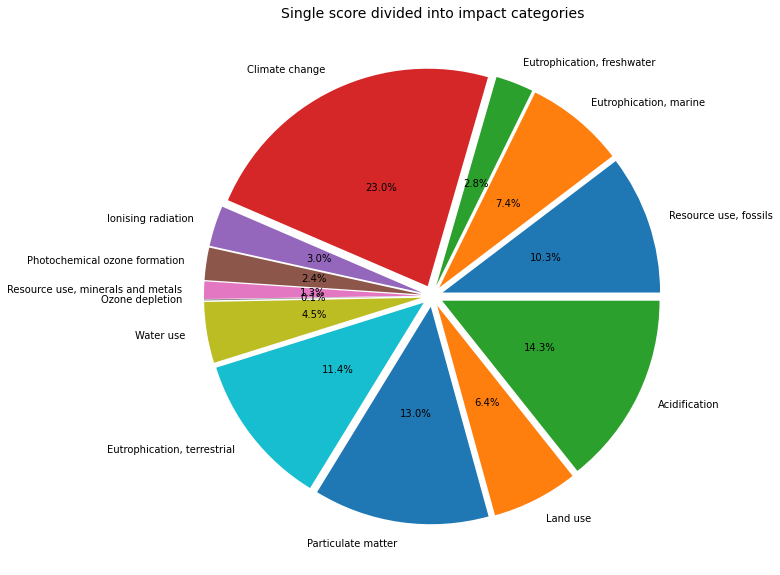

In [10]:
pie, ax = plt.subplots(figsize=[10,10])
labels = nonzero.name
plt.pie(x=nonzero['normalized_and_weighted_result_%'], autopct="%.1f%%", explode=[0.05]*len(nonzero), labels=labels, pctdistance=0.5)
plt.title("Single score divided into impact categories", fontsize=14);

In [11]:
#same chart with plotly library 

fig = px.pie(nonzero, values='normalized_and_weighted_result_%', names = 'name')
fig.show()

## Results per ingredient

The *result_per_ingredient.csv* file contains the contribution of each ingredient to the different impact categories. It contains the following features: 
- *impact_category* : environmental category to which we refer
- *contribution* : contribution of the given ingredient to the given impact category in percentage
- *process* : name of the ingredient (according to the Agribalyse database)
- *amount* : contribution in absolute value
- *unit* : impact category unit

In [12]:
ingredients.head()

,impact_category,contribution,process,amount,unit
0,"Human toxicity, non-cancer",100.00%,"Pizza, vegetables or pizza 4 seasons, at plant...",8.924770e-08,CTUh
1,"Human toxicity, non-cancer",48.72%,"Mozzarella cheese, from cow's milk, at plant - FR",4.347850e-08,CTUh
2,"Human toxicity, non-cancer",41.53%,"Cooked ham, case ready, at plant - FR",3.706390e-08,CTUh
3,"Human toxicity, non-cancer",04.75%,"Cooking, industrial, 1kg of cooked product (AG...",4.235500e-09,CTUh
4,"Human toxicity, non-cancer",03.69%,"Tomato, for processing, peeled, at plant - FR",3.290810e-09,CTUh


In [13]:
ingredients_only = ingredients.drop(ingredients.loc[ingredients.contribution == '100.00%'].index)
ingredients_only.head()

,impact_category,contribution,process,amount,unit
1,"Human toxicity, non-cancer",48.72%,"Mozzarella cheese, from cow's milk, at plant - FR",4.347850e-08,CTUh
2,"Human toxicity, non-cancer",41.53%,"Cooked ham, case ready, at plant - FR",3.706390e-08,CTUh
3,"Human toxicity, non-cancer",04.75%,"Cooking, industrial, 1kg of cooked product (AG...",4.235500e-09,CTUh
4,"Human toxicity, non-cancer",03.69%,"Tomato, for processing, peeled, at plant - FR",3.290810e-09,CTUh
5,"Human toxicity, non-cancer",00.70%,"Wheat flour, at industrial mill - FR",6.251250e-10,CTUh


What are the different ingredients composing this pizza ?

In [14]:
list(ingredients_only.process.unique())

["Mozzarella cheese, from cow's milk, at plant - FR",
 'Cooked ham, case ready, at plant - FR',
 'Cooking, industrial, 1kg of cooked product (AGB 3.0)/ - FR',
 'Tomato, for processing, peeled, at plant - FR',
 'Wheat flour, at industrial mill - FR',
 'Mushroom, peeled, at processing - FR',
 'Water, municipal - FR']

What are the contributions of each ingrediant to climate change ?

In [15]:
ingredients_climate_change = ingredients_only[ingredients_only.impact_category == 'Climate change']
ingredients_climate_change

,impact_category,contribution,process,amount,unit
25,Climate change,58.06%,"Mozzarella cheese, from cow's milk, at plant - FR",2.136840,kg CO2 eq
26,Climate change,33.90%,"Cooked ham, case ready, at plant - FR",1.247870,kg CO2 eq
27,Climate change,03.51%,"Cooking, industrial, 1kg of cooked product (AG...",0.129070,kg CO2 eq
28,Climate change,02.72%,"Wheat flour, at industrial mill - FR",0.100210,kg CO2 eq
29,Climate change,01.40%,"Tomato, for processing, peeled, at plant - FR",0.051590,kg CO2 eq
30,Climate change,00.41%,"Mushroom, peeled, at processing - FR",0.014930,kg CO2 eq
31,Climate change,00.00%,"Water, municipal - FR",0.000048,kg CO2 eq


In [1]:
ingredients_climate_change = ingredients_climate_change.drop(ingredients_climate_change.loc[ingredients_climate_change.contribution == 0.00].index)
pie, ax = plt.subplots(figsize=[10,10])
labels = ingredients_climate_change.process
plt.pie(x=ingredients_climate_change.contribution, autopct="%.1f%%", explode=[0.05]*len(ingredients_climate_change.process), labels=labels, pctdistance=0.5)
plt.title("Contribution of each ingredient to climate change", fontsize=14)

NameError: name 'ingredients_climate_change' is not defined

# Second step : comparison between several meals

Six meals have been selected among the Agribalyse database:
- *Pizza, vegetables or pizza 4 seasons, at plant/FR U*
- *Paella, at plant/FR U*
- *Pork sausage stew with cabbage, carrots and potatoes, at plant/FR U*
- *Sandwich made with French bread, chicken, raw vegetables (lettuce & tomato) and mayonnaise, at plant/FR U*
- *Tartiflette (cheese fondue), at plant/FR U*
- *Carbonara-style pasta (spaghetti, tagliatelle…), at plant/FR U*  

For each of these 6 meals, the following environmental impacts correspond to 1 kg of food. Considering that the functional unit of such a Life Cycle Assessment would be *Have a complete meal at one of EPFL's cafeteria*, we consider that a meal is roughly defined by a certain mass of food, i.e. meals are compared for equal masses (in our case, 1 kg).   

In the following work, the six meals are respectively called: *pizza*, *paella*, *pork meal*, *sandwich*, *tartiflette* and *pasta*.  

In [34]:
comparison = comparison.merge(categories[['name', 'normalization_factor', 'weighting']], how='inner', on='name')
comparison.head()


,name,impact_result,unit,meal,normalization_factor,weighting
0,"Human toxicity, non-cancer",1.693710e-07,CTUh,Pork meal,0.00023,0.0
1,"Human toxicity, non-cancer",2.054610e-07,CTUh,Sandwich,0.00023,0.0
2,"Human toxicity, non-cancer",8.269390e-08,CTUh,Tartiflette,0.00023,0.0
3,"Human toxicity, non-cancer",3.534690e-07,CTUh,Pasta,0.00023,0.0
4,"Human toxicity, non-cancer",7.292580e-08,CTUh,Paella,0.00023,0.0


In [35]:
comparison['normalized_result'] = comparison['impact_result']/comparison['normalization_factor']
comparison['normalized_and_weighted_result'] = comparison['normalized_result']*comparison['weighting']
comparison.head()

,name,impact_result,unit,meal,normalization_factor,weighting,normalized_result,normalized_and_weighted_result
0,"Human toxicity, non-cancer",1.693710e-07,CTUh,Pork meal,0.00023,0.0,0.000737,0.0
1,"Human toxicity, non-cancer",2.054610e-07,CTUh,Sandwich,0.00023,0.0,0.000895,0.0
2,"Human toxicity, non-cancer",8.269390e-08,CTUh,Tartiflette,0.00023,0.0,0.000360,0.0
3,"Human toxicity, non-cancer",3.534690e-07,CTUh,Pasta,0.00023,0.0,0.001539,0.0
4,"Human toxicity, non-cancer",7.292580e-08,CTUh,Paella,0.00023,0.0,0.000318,0.0


In [36]:
score_comparison = comparison[['meal','normalized_and_weighted_result', 'name']]
single_scores = score_comparison.groupby(['meal']).sum()
single_scores.head()

,normalized_and_weighted_result
meal,
Beef,0.413274
Hamburger,0.388432
Paella,0.039638
Pasta,0.177185
Pizza,0.043850


Text(0, 0.5, 'Meal')

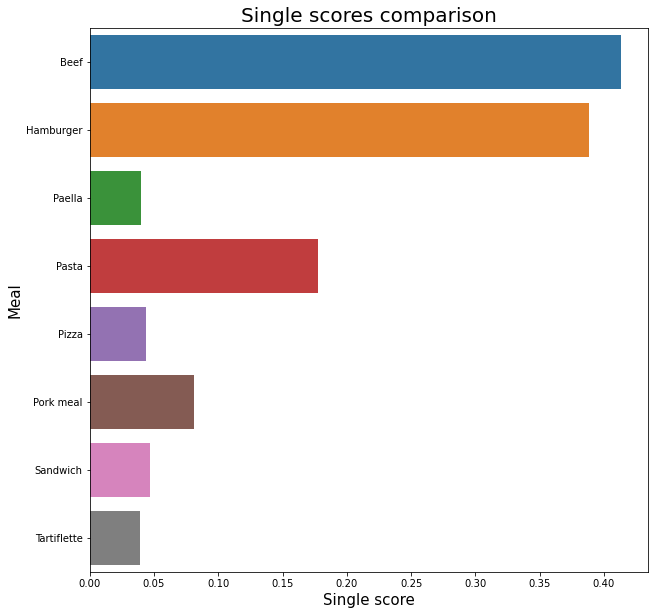

In [37]:
plt.figure(figsize=(10,10));
ax = sns.barplot(y=single_scores.index, x=single_scores.normalized_and_weighted_result, orient='h');
ax.set_title("Single scores comparison", fontsize=20)
ax.set_xlabel('Single score', fontsize = 15)
ax.set_ylabel('Meal', fontsize = 15)

In [38]:
#same chart with plotly

fig = px.bar(single_scores, x = single_scores.index, y = single_scores.normalized_and_weighted_result)
fig.show()


Normalisation to have scores in the range (0,1,2,3,4,5):

In [65]:
max_score = single_scores.normalized_and_weighted_result.max()
min_score = single_scores.normalized_and_weighted_result.min()
#print( single_scores, max_score, min_score)

scores_5 = single_scores
scaled_score =  5* abs(single_scores.normalized_and_weighted_result - max_score)/abs(min_score-max_score)
scores_5.normalized_and_weighted_result = scaled_score

fig = px.bar(scores_5, x = single_scores.index, y = single_scores.normalized_and_weighted_result)
fig.show()


In [22]:
#By meal, comparison of impacts by categories
paella = score_comparison.loc[score_comparison['meal'] == 'Paella']
paella.head()

fig = px.bar(paella, x=paella.name, y = paella.normalized_and_weighted_result, title = 'Comparison of the impact of 1kg of paella by category')
fig.show()

fig2 = px.pie(paella, values='normalized_and_weighted_result', names = 'name', title = 'Comparison of the relative impact of 1kg of paella by category')
fig2.show()

In [23]:
pasta = score_comparison.loc[score_comparison['meal'] == 'Pasta']
pasta.head()

fig = px.bar(pasta, x=pasta.name, y = pasta.normalized_and_weighted_result, title = 'Comparison of the impact of 1kg of pasta carbonara by category')
fig.show()

fig2 = px.pie(pasta, values='normalized_and_weighted_result', names = 'name', title = 'Comparison of the relative impact of 1kg of pasta carbonara by category')
fig2.show()